# Dataset creation for sign spotting
Here, we preprocess the data from the Corpus NGT and split it up by its annotations. The data corresponding to an annotation are then sampled so they are of a fixed length. 

If the target fixed length is X frames, we can check if an annotation is already X frames long. If so, we can simply add its (preprocessed) data as a new entry in the train, validation or test set. If instead the length of the annotation is less than X frames, we add zero padding. 

If the annotation is longer than X frames, we undersample the frames. For instance, assuming we have a target length X=10 and an annotation with 22 frames, we first drop every other (every second) frame to get to 11 frames. We do not use random undersampling here to ensure at least some of the temporal structure of the annotation is maintained. Then, we drop 1 more frame randomly to get to our target of 10 frames.

We first create the dataset using the above method, before repeating the 'dataset creation' for the purposes of checking the correlation between the used features. The repeat is needed because for the correlation analysis, we do not want to  undersampling and zero padding be done, we simply use the annotations at their original length. After preparing for the correlation analysis, we use masking of the NaN values to not skew the correlation (e.g. by replacing NaNs with zeros). Lastly, we find out which features have correlation above some threshold so we can discard them before training our sign spotting model.

**Note:** this notebook should be run *twice*, once with `ling_features = True` and once with `ling_features = False`. See the code block after the imports for where to change this variable.

In [1]:
# Imports
import pympi
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
from sklearn import preprocessing

import importlib

# Keep python tools up to date
from tools import tools, feature_extraction, constants, mediapipe_tools, make_dataset
importlib.reload(mediapipe_tools)
importlib.reload(tools)
importlib.reload(constants)
importlib.reload(feature_extraction)
importlib.reload(make_dataset)

# Import all functions from the tools
from tools.tools import*
from tools.mediapipe_tools import normalise_coordinates, get_pixel_coordinates
from tools.constants import PATHS, ANN_LENGTH # Path constants
from tools.feature_extraction import get_wrist_angle_distance
from tools.make_dataset import make_dataset, norm

np.random.seed(123) # Set random seed for consistency

In [2]:
# Here we pick if we want to make a dataset with feature extraction (based on linguistics)
# Or if we want to just extract the landmarks (done if ling_features = False)
ling_features = True

# We find all of the landmark files, split up by the different areas
# E.g. 'face' has its own numpy file for each video
path = PATHS['np_landmarks']
cngt_lmrks = find_files(path, '.npy')
print('Number of CNGT files when split into numpy files:', len(cngt_lmrks))

Number of CNGT files when split into numpy files: 3420


In [3]:
# Root where all the annotated .eaf sign files are present
dataset_root = PATHS['cngt_vids_and_eaf']

# This is a path to a file of annotations tailored to the dataset creation
# It only distinguishes between handedness, not manual simultaneity
# Because we don't care about whether another sign is produced simultaneously
# For making the dataset, we only want to make sure two-handed signs
# Are added once as an annotation and not twice, so that's why we distinguish handedness
dataset_anns_path = PATHS['dataset_anns']

# List the .eaf files in the root directory to investigate
anns_in_dir = [file for file in os.listdir(dataset_root) if file.endswith('.eaf')]

# Loading the annotations for the dataset-tailored annotations
# Or we create them if they don't exist yet
if os.path.exists(dataset_anns_path):
    print('Loading annotations...')
    anns_with_tiers = load_dict(dataset_anns_path)
else:
    print('Making annotations without manual simultaneity...')
    anns_with_tiers = {}
    for i, ann_file in enumerate(anns_in_dir):
        print(i, end = '\r')
        # Read in the Eaf file 
        eaf_file = pympi.Elan.Eaf(os.path.join(dataset_root, ann_file))

        # Get the glosses and mouthings of the file
        anns_dict, _ = get_gloss_vals(eaf_file, True)
        # As explained above, we only distinguish handedness and not simultaneity
        anns_dict = man_sim_and_hand_dist(anns_dict, manual_sim = False)

        # Store the glosses, mouthings and tiers
        anns_with_tiers[ann_file] = anns_dict
    print('Storing...')
    with open(dataset_anns_path, 'wb') as f:
        pickle.dump(anns_with_tiers, f)
        
# Signbank dictionary info
df = pd.read_csv(PATHS['signbank_with_linguistics'])

# Dictionary which contains which videos (and signers) belong in test/train set
id_split = load_dict(PATHS['CNGT_split_ids'])

# Using only the top X signs if we have a list of them
top = -1 #1000
top_signs_path = PATHS['top_signs'].format(top)
if os.path.exists(top_signs_path):
    top_signs = np.load(top_signs_path)
else:
    top_signs = []

Loading annotations...


In [4]:
print('Signer split across train, validation and test sets')
# Printing which signers belong in the train, validation and test set
for key in id_split:
    print(key, sorted(set([x.split('_')[-1] for x in id_split[key]])))
# Note that the val and test sets are allowed to have the same signers (same Sxxx)
# But that they should contain different videos
val_vids = id_split['Val']
test_vids = id_split['Test']

Signer split across train, validation and test sets
Train ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S043', 'S044', 'S045', 'S049', 'S050', 'S059', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S075', 'S076', 'S077', 'S078', 'S083', 'S084', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092']
Val ['S011', 'S012', 'S019', 'S020', 'S027', 'S028', 'S039', 'S040', 'S041', 'S045', 'S046', 'S047', 'S048', 'S051', 'S052', 'S055', 'S056', 'S058', 'S071', 'S072', 'S073', 'S074', 'S079', 'S080', 'S081', 'S082', 'S085', 'S086']
Test ['S011', 'S012', 'S019', 'S020', 'S027', 'S028', 'S039', 'S040', 'S041', 'S042', 'S045', 'S046', 'S047', 'S048', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S071', 'S072', 'S073', 'S074', 'S080', 'S

# Data preprocessing and feature extraction
**Note:** this codeblock can take a while to run with `ling_features = True` due to the preprocessing and extraction for each video being computationally heavy. With `ling_features = False` this should only take a few minutes.

*Expected runtime: 15-30min (with ling_features = True)*

In [5]:
%%time
features = '' if ling_features else '_only_lmrks'

# Path where the extracted features are stored
features_path = PATHS['features_data'].format(features)

# If the extracted features are not saved yet, we create them and then store them
if not os.path.exists(features_path):
    print('Creating feature-extracted data...')
    features_data = {}
    for i, k in enumerate(anns_with_tiers):
        print('Extracting features for video {}/{}'.format(i+1, len(list(anns_with_tiers.keys()))), end = '\r')
        # Get the glosses of the file
        anns_dict = anns_with_tiers[k]
    
        # Loading the numpy files for a specific video
        lmrk_dict = load_numpy(cngt_lmrks, k.replace('.eaf', ''))
        # Normalize the coordinates, also create a horizontally flipped version
        lmrk_dict = normalise_coordinates(get_pixel_coordinates(lmrk_dict))
        pose = lmrk_dict['pose']
        
        lmrk_dict['l_hand'][:, [0,4,5,17], :] = pose[:, [15,17,19,21], :]
        lmrk_dict['r_hand'][:, [0,4,5,17], :] = pose[:, [16,18,20,22], :]
        
        if 'only_lmrks' in features_path:
            l_lmrk = lmrk_dict['l_hand']
            r_lmrk = lmrk_dict['r_hand']
            shape = l_lmrk.shape
            l_lmrk = l_lmrk.reshape(shape[0], -1).astype(np.float32)
            r_lmrk = r_lmrk.reshape(shape[0], -1).astype(np.float32)
        else:
            # Getting landmarks preprocessed, with new format being (wrist, distances, angles) for each frame
            l_lmrk = get_wrist_angle_distance(lmrk_dict, 'l_hand', pose).astype(np.float32)
            r_lmrk = get_wrist_angle_distance(lmrk_dict, 'r_hand', pose).astype(np.float32)
        # Store in the dictionary
        features_data[k] = {'l_hand' : l_lmrk, 'r_hand': r_lmrk}
    
    # Store the extracted features in a numpy file (faster than pickling)
    features_data_np = np.array(list(features_data.items()))
    np.save(features_path, features_data_np)
        
else:
    print('Feature-extracted data exists, loading...')
    # Allow pickle has to be true because we have nested dictionaries
    features_data = dict(np.load(features_path, allow_pickle = True))
print('Done!')

Feature-extracted data exists, loading...
Done!
CPU times: total: 2.69 s
Wall time: 29 s


# Creating the dataset

In [6]:
%%time
fixed_length = ANN_LENGTH
X, y, stats, var_len, ann_lengths, glosses = make_dataset(anns_with_tiers, features_data, df, val_vids, test_vids, 
                                                          top_signs, id_split, fixed_length=fixed_length, 
                                                          zero_pad=True, ling_features = ling_features)
empty, smaller, precise, larger = stats
X_train_var_len, y_train_var_len = var_len

(7, 59) (7, 59)o 1/855
(7, 59) (7, 59)
(7, 59) (7, 59)
(25, 59) (25, 59)
(27, 59) (27, 59)
(7, 59) (7, 59)
(19, 59) (19, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(21, 59) (21, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(24, 59) (24, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(9, 59) (9, 59)
(18, 59) (18, 59)
(9, 59) (9, 59)
(24, 59) (24, 59)
(15, 59) (15, 59)
(20, 59) (20, 59)
(13, 59) (13, 59)
(17, 59) (17, 59)
(16, 59) (16, 59)
(12, 59) (12, 59)
(21, 59) (21, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(12, 59) (12, 59)
(14, 59) (14, 59)
(17, 59) (17, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(54, 59) (54, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(36, 59) (36, 59)
(16, 59) (16, 59)
(7, 5

(10, 59) (10, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(26, 59) (26, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(27, 59) (27, 59)
(20, 59) (20, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(20, 59) (20, 59)
(20, 59) (20, 59)
(12, 59) (12, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(18, 59) (18, 59)
(15, 59) (15, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(24, 59) (24, 59)
(16, 59) (16, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(16, 59) (16, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(32, 59) (32, 59)
(22, 59) (22, 59)
(12, 59) (12, 59)
(16, 59) (16, 59)
(12, 59) (12

(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(19, 59) (19, 59)
(13, 59) (13, 59)
(81, 59) (81, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(50, 59) (50, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(46, 59) (46, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(37, 59) (37, 59)
(23, 59) (23, 59)
(33, 59) (33, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(11,

(18, 59) (18, 59)13/855
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(20, 59) (20, 59)
(12, 59) (12, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(30, 59) (30, 59)
(35, 59) (35, 59)
(14, 59) (14, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(22, 59) (22, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(22, 59) (22, 59)
(8, 59) (8, 59)
(24, 59) (24, 59)
(21, 59) (21, 59)
(17, 59) (17, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(29, 59) (29, 59)
(27, 59) (27, 59)
(17, 59) (17, 59)
(63, 59) (63, 59)
(39, 59) (39, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(30, 59) (30, 59)
(14, 59) (14, 59)
(20, 59) (20, 59)
(36, 59) (36, 59)
(11, 59) (11, 59)
(27, 59) (27, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)o 14/855
(11, 59) (11, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(40,

(11, 59) (11, 59)18/855
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(86, 59) (86, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(36, 59) (36, 59)
(25, 59) (25, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(24, 59) (24, 59)
(6, 59) (6, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(23, 59) (23, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(22, 59) (22, 59)
(16, 59) (16, 59)
(16, 59) (16, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(10, 59)

(5, 59) (5, 59)o 22/855
(6, 59) (6, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(21, 59) (21, 59)
(12, 59) (12, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(16, 59) (16, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(26, 59) (26, 59)
(11, 59) (11, 59)
(16, 59) (16, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(7, 59) (7, 

(2, 59) (2, 59)o 27/855
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(18, 59) (18, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(1

(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(29, 59) (29, 59)
(14, 59) (14, 59)
(54, 59) (54, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(16, 59) (16, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(8, 59) (8, 

(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(9, 59) (9, 59)
(18, 59) (18, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(17, 59) (17, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(22, 59) (22, 59)
(41, 59) (41, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(15, 5

(60, 59) (60, 59)
(66, 59) (66, 59)
(25, 59) (25, 59)
(9, 59) (9, 59)
(39, 59) (39, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(21, 59) (21, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(25, 59) (25, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(36, 59) (36, 59)
(36, 59) (36, 59)
(7, 59) (7, 59)o 37/855
(15, 59) (15, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(12, 59) (

(30, 59) (30, 59)40/855
(21, 59) (21, 59)
(21, 59) (21, 59)
(11, 59) (11, 59)
(25, 59) (25, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(22, 59) (22, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(28, 59) (28, 59)
(20, 59) (20, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(38, 59) (38, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(5

(10, 59) (10, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(16, 59) (16, 59)
(25, 59) (25, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(27, 59) (27, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(24, 59) (24, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(19, 59) (19, 59)
(19, 59) (19, 59)
(16, 59) (16, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(22, 59) (22, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(25, 59) (25, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(21, 59) (21, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)


(37, 59) (37, 59)47/855
(18, 59) (18, 59)
(6, 59) (6, 59)
(24, 59) (24, 59)
(10, 59) (10, 59)
(38, 59) (38, 59)
(17, 59) (17, 59)
(9, 59) (9, 59)
(24, 59) (24, 59)
(21, 59) (21, 59)
(8, 59) (8, 59)
(74, 59) (74, 59)
(8, 59) (8, 59)
(18, 59) (18, 59)
(27, 59) (27, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(15, 59) (15, 59)
(32, 59) (32, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(31, 59) (31, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(37, 59) (37, 59)
(21, 59) (21, 59)
(21, 59) (21, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(25, 59) (25, 59)
(15, 59) (15, 59

(13, 59) (13, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(46, 59) (46, 59)
(25, 59) (25, 59)
(20, 59) (20, 59)
(42, 59) (42, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(24, 59) (24, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(50, 59) (50, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)


(9, 59) (9, 59)
(18, 59) (18, 59)
(15, 59) (15, 59)
(21, 59) (21, 59)
(46, 59) (46, 59)
(9, 59) (9, 59)
(19, 59) (19, 59)
(20, 59) (20, 59)
(11, 59) (11, 59)
(17, 59) (17, 59)
(29, 59) (29, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(21, 59) (21, 59)
(7, 59) (7, 59)
(23, 59) (23, 59)
(29, 59) (29, 59)
(92, 59) (92, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(19, 59) (19, 59)
(40, 59) (40, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(107, 59) (107, 59)
(107, 59) (107, 59)
(47, 59) (47, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(40, 59) (40, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(92, 59) (92, 59)
(92, 59) (92, 59)
(9, 59) (9, 59)
(34, 59) (34, 59)
(24, 59) (24, 59)
(40, 59) (40, 59)
(37, 59) (37, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(18, 59) (18, 59)
(39, 59) (39, 59)
(22, 59) (22, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(18, 59) (18, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(13, 59) (13, 

(18, 59) (18, 59)58/855
(13, 59) (13, 59)
(36, 59) (36, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(17, 59) (17, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(31, 59) (31, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(67, 59) (67, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(12, 59) (12, 59)
(2, 59) (2, 59)


(6, 59) (6, 59)o 61/855
(7, 59) (7, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(21, 59) (21, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(14, 59) (14, 59)
(29, 59) (29, 59)
(12, 59) (12, 59)
(15, 59) (15, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 

(30, 59) (30, 59)65/855
(5, 59) (5, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(24, 59) (24, 59)
(19, 59) (19, 59)
(30, 59) (30, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(24, 59) (24, 59)
(20, 59) (20, 59)
(32, 59) (32, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)


(6, 59) (6, 59)o 69/855
(7, 59) (7, 59)
(16, 59) (16, 59)
(113, 59) (113, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(20, 59) (20, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(18, 59) (18, 59)
(9, 59) (9, 59)
(11, 59) (11, 

(8, 59) (8, 59)o 74/855
(7, 59) (7, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(41, 59) (41, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(20, 59) (20, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(2, 59) (2

(36, 59) (36, 59)78/855
(6, 59) (6, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(7, 59) (7, 59)
(41, 59) (41, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(73, 59) (73, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(25, 59) (25, 59)
(8, 59) (8, 59)
(21, 59) (21, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(23, 59) (23, 59)
(13, 59) (13, 59)
(23, 59) (23, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(22, 59) (22, 59)
(8, 59) (8, 59)
(3, 59) (3, 59

(10, 59) (10, 59)81/855
(7, 59) (7, 59)
(22, 59) (22, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(19, 59) (19, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(34, 59) (34, 59)
(14, 59) (14, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(51, 59) (51, 59)
(11, 59) (11, 59)
(21, 59) (21, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)82/855
(5, 59) 

(8, 59) (8, 59)o 86/855
(9, 59) (9, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(21, 59) (21, 59)
(21, 59) (21, 59)
(15, 59) (15, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(46, 59) (46, 59)
(12, 59) (12, 59)
(30, 59) (30, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(34, 59) (34, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(41, 59) (41, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(7, 59) (7

(4, 59) (4, 59)o 91/855
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(23, 59) (23, 59)
(20, 59) (20, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) 

(7, 59) (7, 59)o 96/855
(5, 59) (5, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(62, 59) (62, 59)
(31, 59) (31, 59)
(15, 59) (15, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(21, 59) (21, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(15, 59) (15, 59)
(43, 59) (43, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(17, 59) (17, 59)
(3, 59) (3, 59)
(15, 59) (15, 59)
(11, 59) (11, 59)
(2, 59) (2, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(23, 59) (23, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3

(17, 59) (17, 59)101/855
(21, 59) (21, 59)
(32, 59) (32, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(47, 59) (47, 59)
(7, 59) (7, 59)
(34, 59) (34, 59)
(35, 59) (35, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(2, 59) (2, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(47, 59) (47, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59)

(4, 59) (4, 59)o 104/855
(40, 59) (40, 59)
(41, 59) (41, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(59, 59) (59, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(35, 59) (35, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(35, 59) (35, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(38, 59) (38, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(16, 59) (16, 59)
(28, 59) (28, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(35, 59) (35, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(

(7, 59) (7, 59)o 108/855
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(22, 59) (22, 59)
(10, 59) (10, 59)
(102, 59) (102, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(38, 59) (38, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(18, 59) (18, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(35, 59) (35, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(

(20, 59) (20, 59)112/855
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(28, 59) (28, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(18, 59) (18, 59)
(58, 59) (58, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 5

(6, 59) (6, 59)o 117/855
(2, 59) (2, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 5

(2, 59) (2, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(46, 59) (46, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(24, 59) (24, 59)
(11, 59) (11, 59)
(26, 59) (26, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)


(13, 59) (13, 59)122/855
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(47, 59) (47, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(24, 59) (24, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 5

(6, 59) (6, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(22, 59) (22, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 

(9, 59) (9, 59)o 127/855
(4, 59) (4, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(24, 59) (24, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(24, 59) (24, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(29, 59) (29, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6,

(4, 59) (4, 59)o 129/855
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(25, 59) (25, 59)
(4, 59) (4, 59)
(10, 59

(7, 59) (7, 59)o 133/855
(5, 59) (5, 59)
(4, 59) (4, 59)
(25, 59) (25, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 5

(4, 59) (4, 59)
(29, 59) (29, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(13, 59) (13, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(18, 59) (18, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(25, 59) (25, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(18, 59) (18, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 

(4, 59) (4, 59)o 137/855
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(41, 59) (41, 59)
(21, 59) (21, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(74, 59) (74, 59)
(11, 59) (11, 59)
(34, 59) (34, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)138/855
(10, 59) (10, 59)
(44, 59) (44, 59)
(19, 59) (19, 59)
(8, 59) (8, 59)o 139/855
(8, 59) (8, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(23, 59) (23, 59)
(72, 59) (72, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(81, 59) (81, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (

(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(36, 59) (36, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(70, 59) (70, 59)
(28, 59) (28, 59)
(19, 59) (19, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(6, 59) (6, 

(7, 59) (7, 59)o 144/855
(7, 59) (7, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(24, 59) (24, 59)
(13, 59) (13, 59)
(58, 59) (58, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)145/855
(8, 59) (8, 59)
(41, 59) (41, 59)
(37, 59) (37, 59)
(74, 59) (74, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 

(45, 59) (45, 59)
(34, 59) (34, 59)
(3, 59) (3, 59)
(31, 59) (31, 59)
(3, 59) (3, 59)
(67, 59) (67, 59)
(45, 59) (45, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(27, 59) (27, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(20, 59) (20, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(88, 59) (88, 59)
(3, 59) (3, 59)
(24, 59) (24, 59)
(12, 59) (12, 59)
(19, 59) (19, 59)
(17, 59) (17, 59)
(11, 59) (11, 59)
(23, 59) (23, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(12, 59) (12, 59)
(21, 59) (21, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3

(10, 59) (10, 59)158/855
(6, 59) (6, 59)
(1, 59) (1, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(30, 59) (30, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(39, 59) (39, 59)
(19, 59) (19, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(36, 59) (36, 59)
(3, 59) (3, 59)
(24, 59) (24, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(36, 59) (36, 59)
(8, 59) (8, 59)
(

(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(18, 59) (18, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(20, 59) (20, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(17, 59) (17, 59)
(11, 59) (11, 59)
(29, 59) (29, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) 

(13, 59) (13, 59)167/855
(7, 59) (7, 59)
(23, 59) (23, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(34, 59) (34, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(21, 59) (21, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(21, 59) (21, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(19, 59) (19, 59)
(31, 59) (31, 59)
(14, 59) (14, 59)
(20, 59) (20, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(79, 59) (79, 59)
(27, 59) (27, 59)
(34, 59) (34, 59)
(12, 59) (12, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(27, 59) (27, 5

(10, 59) (10, 59)173/855
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(93, 59) (93, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(18, 59) (18, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(20, 59) (20, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3,

(9, 59) (9, 59)
(18, 59) (18, 59)
(29, 59) (29, 59)
(24, 59) (24, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(39, 59) (39, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(11, 59) (11, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(53, 59) (53, 59)
(6, 59) (6, 59)
(56, 59) (56, 59)
(15, 59) (15, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(8, 

(7, 59) (7, 59)o 181/855
(18, 59) (18, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(17, 59) (17, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3,

(13, 59) (13, 59)
(24, 59) (24, 59)
(81, 59) (81, 59)
(34, 59) (34, 59)
(124, 59) (124, 59)
(33, 59) (33, 59)
(15, 59) (15, 59)
(2, 59) (2, 59)
(13, 59) (13, 59)
(61, 59) (61, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(34, 59) (34, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(29, 59) (29, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(27, 59) (27, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9

(102, 59) (102, 59)5/855
(10, 59) (10, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)
(28, 59) (28, 59)
(22, 59) (22, 59)
(4, 59) (4, 59)
(29, 59) (29, 59)
(71, 59) (71, 59)
(10, 59) (10, 59)
(40, 59) (40, 59)
(13, 59) (13, 59)
(57, 59) (57, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(2, 59) (2, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(22, 59) (22, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(27, 59) (27, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(37, 59) (37, 59)
(17, 59) (17, 59)
(25, 59) (25, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(12

(13, 59) (13, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(42, 59) (42, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(23, 59) (23, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(23, 59) (23, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(35, 59) (35, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(21, 59) (21, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(35, 59) (35, 59)
(17, 59) (17, 59)
(40, 59) (40, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(29, 59) (29, 59)
(30, 59) (30, 59)
(21, 59) (21, 59)
(17, 59) (17, 59)
(20, 59) (20, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(17, 59) (17, 

(5, 59) (5, 59)o 188/855
(6, 59) (6, 59)
(13, 59) (13, 59)
(16, 59) (16, 59)
(15, 59) (15, 59)
(34, 59) (34, 59)
(12, 59) (12, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(20, 59) (20, 59)
(3, 59) (3, 59)
(28, 59) (28, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(41, 59) (41, 59)
(9, 59) (9, 59)
(20, 59) (20, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(17, 59) (17, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)

(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(28, 59) (28, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(17, 59) (17, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(60, 59) (60, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(12, 59) (12, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(54, 59) (54, 59)
(5

(13, 59) (13, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(29, 59) (29, 59)
(4, 59) (4, 59)
(22, 59) (22, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(15, 59) (15, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 

(7, 59) (7, 59)o 197/855
(5, 59) (5, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(22, 59) (22, 59)
(23, 59) (23, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(24, 59) (24, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(54, 59) (54, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(63, 59) (63, 59)
(36, 59) (36, 59)
(27, 59) (27, 59)
(10, 59) (10, 59)
(75, 59) (75, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(30, 59) (30, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(12, 59) (12, 59)
(20, 59) (20, 59)
(5, 59) (5, 59)
(23, 59) (23, 59)
(5, 59) (5, 59)

(19, 59) (19, 59)199/855
(13, 59) (13, 59)
(7, 59) (7, 59)
(86, 59) (86, 59)
(3, 59) (3, 59)
(31, 59) (31, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(26, 59) (26, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(27, 59) (27, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(19, 59) (19, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(20, 59) (20, 59)
(14, 59) (14, 59)
(40, 59) (40, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(11, 

(16, 59) (16, 59)202/855
(12, 59) (12, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(65, 59) (65, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59)

(8, 59) (8, 59)o 208/855
(9, 59) (9, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(38, 59) (38, 59)
(21, 59) (21, 59)
(25, 59) (25, 59)
(19, 59) (19, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(23, 59) (23, 59)
(6, 59) (6, 59)
(24, 59) (24, 59)
(18, 59) (18, 59)
(28, 59) (28, 59)
(66, 59) (66, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(24, 59) (24, 59)
(22, 59) (22, 59)
(8, 59) (8, 59)
(18, 59) (18, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(17, 59) (17, 59)
(14, 59) (14, 59)
(32, 59) (32, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(18, 59) (18, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(11, 59

(14, 59) (14, 59)216/855
(4, 59) (4, 59)
(20, 59) (20, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(18, 59) (18, 59)
(65, 59) (65, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(38, 59) (38, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(26, 59) (26, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(26, 59) (26, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(21, 59) (21, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(16, 59) (16, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(6, 59) (

(23, 59) (23, 59)225/855
(32, 59) (32, 59)
(24, 59) (24, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(25, 59) (25, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(19, 59) (19, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(16, 59) (16, 59)
(27, 59) (27, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(27, 59) (27, 59)
(17, 59) (17, 59)
(28, 59) (28, 59)
(16, 59) (16, 59)
(18, 59) (18, 59)226/855
(22, 59) (22, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 

(12, 59) (12, 59)232/855
(37, 59) (37, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(17, 59) (17, 59)
(23, 59) (23, 59)
(10, 59) (10, 59)
(52, 59) (52, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(28, 59) (28, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(27, 59) (27, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(11, 59) (11, 59)
(37, 59) (37, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(29, 59) (29, 59)
(23, 59) (23, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(22, 59) (22, 59)
(13, 59) (13, 59)
(20, 59) (20, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(28, 59) (28, 59)233/855
(8, 59) (8, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(9, 

(16, 59) (16, 59)
(4, 59) (4, 59)
(39, 59) (39, 59)
(18, 59) (18, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(25, 59) (25, 59)
(6, 59) (6, 59)
(18, 59) (18, 59)
(75, 59) (75, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(36, 59) (36, 59)242/855
(35, 59) (35, 59)
(10, 59) (10, 59)
(22, 59) (22, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(21, 59) (21, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(21, 59) (21, 59)
(4, 59) (4, 59)
(48, 59) (48, 59)
(19, 59) (19, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(25, 59) (25, 59)
(12, 59) (12, 59)
(17, 59) (17, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(25, 59) (25, 59)
(9, 59) (9, 59)
(15, 59

(3, 59) (3, 59)o 249/855
(9, 59) (9, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(43, 59) (43, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(28, 59) (28, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(35, 59) (35, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(13, 59) (13, 59)
(27, 59) (27, 59)
(13, 59) (13, 59)
(23, 59) (23, 5

(14, 59) (14, 59)255/855
(12, 59) (12, 59)
(17, 59) (17, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(23, 59) (23, 59)
(31, 59) (31, 59)
(15, 59) (15, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(22, 59) (22, 59)
(28, 59) (28, 59)
(22, 59) (22, 59)
(20, 59) (20, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(18, 59) (18, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(30, 59) (30, 59)
(29, 59) (29, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(47, 59) 

(10, 59) (10, 59)
(42, 59) (42, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(26, 59) (26, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(15, 59) (15, 59)
(11, 59) (11, 59)
(15, 59) (15, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(16, 59) (16, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(35, 59) (35, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(21, 59) (21, 59)
(16, 59) (16, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(30, 59) (30, 59)
(13, 59) (13, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(48, 59) (48, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(62, 59) (62, 59)259/855
(3, 59) (3, 59)
(27, 59) (27, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(23, 59) (23, 59)
(10, 59) (10, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(106, 59) (106, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(10, 

(27, 59) (27, 59)263/855
(14, 59) (14, 59)
(71, 59) (71, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(11, 59) (11, 59)
(116, 59) (116, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(17, 59) (17, 59)
(13, 59) (13, 59)
(15, 59) (15, 59)
(12, 59) (12, 59)
(23, 59) (23, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(28, 59) (28, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(15, 59) (15, 59)
(42, 59) (42, 59)
(42, 59) (42, 59)
(11, 59) (11, 59)
(21, 59) (21, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(17, 59

(15, 59) (15, 59)268/855
(4, 59) (4, 59)
(55, 59) (55, 59)
(56, 59) (56, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(24, 59) (24, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(18, 59) (18, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(24, 59) (24, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(17, 59) (17, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)

(12, 59) (12, 59)272/855
(7, 59) (7, 59)
(23, 59) (23, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(34, 59) (34, 59)
(170, 59) (170, 59)
(175, 59) (175, 59)
(269, 59) (269, 59)
(25, 59) (25, 59)
(43, 59) (43, 59)
(5, 59) (5, 59)
(23, 59) (23, 59)
(89, 59) (89, 59)
(16, 59) (16, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(30, 59) (30, 59)
(22, 59) (22, 59)
(9, 59) (9, 59)
(20, 59) (20, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(36, 59) (36, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(26, 59) (26, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(21, 59) (21, 59)
(28, 59) (28, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 5

(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(36, 59) (36, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(3, 59) (3, 59)
(26, 59) (26, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(26, 59) (26, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(19, 59) (19, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4

(5, 59) (5, 59)o 285/855
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(17, 59) (17, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(44, 59) (44, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(19, 59) (19, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(25, 59) (25, 59)
(22, 59) (22, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(23, 59) (23, 59)
(27, 59) (27, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(27, 59) (27, 59)
(21, 59) (21, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4,

(7, 59) (7, 59)o 290/855
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(22, 59) (22, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(29, 59) (29, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(30, 59) (30, 59)
(5, 59) (5, 59)
(35, 59) (3

(6, 59) (6, 59)o 294/855
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(32, 59) (32, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(27, 59) (27, 59)
(3, 59) (3, 59)
(21, 59) (21, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(45, 59) (45, 59)
(16, 59) (16, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(14, 59) (14, 59)

(6, 59) (6, 59)o 307/855
(22, 59) (22, 59)
(10, 59) (10, 59)
(39, 59) (39, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(19, 59) (19, 59)
(19, 59) (19, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(

(18, 59) (18, 59)313/855
(18, 59) (18, 59)314/855
(12, 59) (12, 59)
(13, 59) (13, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(30, 59) (30, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(31, 59) (31, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(10, 59) (10, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(30, 59) (30, 59)
(19, 59) (19, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(18, 59) (18, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(41, 59) (41, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(32, 59) (32, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(21, 59) (21, 59)
(36, 5

(8, 59) (8, 59)o 321/855
(8, 59) (8, 59)
(33, 59) (33, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(31, 59) (31, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(62, 59) (62, 59)
(30, 59) (30, 59)
(10, 59) (10, 59)
(28, 59) (28, 59)
(20, 59) (20, 59)
(20, 59) (20, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(20, 59) (20, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(38, 59) (38, 59)
(7, 59) (7, 59)
(19, 59) (19, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(6, 5

(41, 59) (41, 59)326/855
(11, 59) (11, 59)
(12, 59) (12, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(29, 59) (29, 59)
(70, 59) (70, 59)
(30, 59) (30, 59)
(11, 59) (11, 59)
(23, 59) (23, 59)
(43, 59) (43, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(15, 59) (15, 59)
(20, 59) (20, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(19, 59) (19, 59)
(12, 59) (12, 59)
(17, 59) (17, 59)
(19, 59) (19, 59)
(17, 59) (17, 59)
(14, 59) (14, 59)
(23, 59) (23, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(20, 59) (20, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(10

(5, 59) (5, 59)o 331/855
(5, 59) (5, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(36, 59) (36, 59)
(13, 59) (13, 59)
(126, 59) (126, 59)
(130, 59) (130, 59)
(18, 59) (18, 59)
(17, 59) (17, 59)
(24, 59) (24, 59)
(21, 59) (21, 59)
(22, 59) (22, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(42, 59) (4

(14, 59) (14, 59)335/855
(16, 59) (16, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(13, 59) (13, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(23, 59) (23, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(27, 59) (27, 59)
(7, 59) (7, 59)
(

(11, 59) (11, 59)345/855
(4, 59) (4, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(18, 59) (18, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(19, 59) (19, 59)
(2, 59) (2, 59)
(21, 59) (21, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(29, 59) (29, 59)
(22, 59) (22, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(36, 59) (36, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(4,

(5, 59) (5, 59)o 348/855
(37, 59) (37, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(20, 59) (20, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(26, 59) (26, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(22, 59) (22, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(20, 59) (20, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(18, 59) (18, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(22, 59) (22, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5,

(2, 59) (2, 59)o 352/855
(11, 59) (11, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(31, 59) (31, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(32, 59) (32, 59)
(6, 59) (6, 59)
(50, 59) (50, 59)
(30, 59) (30, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(16, 59) (16, 59)
(2, 59) (2, 59)
(19, 59) (19, 59)
(27, 59) (27, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(9, 59) (9, 5

(6, 59) (6, 59)o 354/855
(6, 59) (6, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(15, 59) (15, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(22, 59) (22, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(26, 59) (26, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(34, 59) (34, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8,

(4, 59) (4, 59)o 357/855
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(20, 59) (20, 59)
(4, 59) (4, 59)
(29, 59) (29, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(17, 59) (17, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(52, 59) (52, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(22, 59) (22, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(6, 59) (

(4, 59) (4, 59)o 365/855
(15, 59) (15, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(21, 59) (21, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(30, 59) (30, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)o 366/855
(7, 59) (7, 59)
(7, 59) (7, 59)
(7, 59) (7, 59

(70, 59) (70, 59)372/855
(32, 59) (32, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(25, 59) (25, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(7, 5

(25, 59) (25, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(37, 59) (37, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(30, 59) (30, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(26, 59) (26, 59)
(74, 59) (74, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(32, 59) (32, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(19, 59) (19, 59)
(5, 59) (5, 59)
(53, 59) (53, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59

(9, 59) (9, 59)o 381/855
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(33, 59) (33, 59)
(7, 59) (7, 59)
(21, 59) (21, 59)
(35, 59) (35, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(21, 59) (21, 59)
(9, 59) (9, 59)
(35, 59) (35, 59)
(2, 59) (2, 59)
(19, 59) (19, 59)
(19, 59) (19, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(25, 59) (25, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(40, 59) (40, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(24, 59) (24, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(

(6, 59) (6, 59)
(9, 59) (9, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(23, 59) (23, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(23, 59) (23, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(28, 59) (28, 59)
(24, 59) (24, 59)
(25, 59) (25, 59)
(22, 59) (22, 59)
(8, 59) (8, 59)
(22, 59) (22, 59)
(22, 59) (22, 59)
(45, 59) (45, 59)
(43, 59) (43, 59)
(65, 59) (65, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(57, 59) (57, 59)
(59, 59) (59, 59)
(7, 59) (7, 59)
(19, 59) (19, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(35, 59) (35, 59)
(15, 59) (15, 59)
(30, 59) (30, 59)
(7, 59) (7, 59)
(26, 59) (26, 59)
(25, 59) (25, 59)
(22, 59) (22, 59)
(12, 59) (12, 59)
(21, 59) (21, 59)
(24,

(12, 59) (12, 59)387/855
(16, 59) (16, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(141, 59) (141, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(17, 59) (17, 59)
(33, 59) (33, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 5

(10, 59) (10, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(27, 59) (27, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(9, 59) (9, 59)
(42, 59) (42, 59)
(11, 59) (11, 59)
(18, 59) (18, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(29, 59) (29, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(7, 59) (7, 59

(3, 59) (3, 59)o 397/855
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(15, 59) (15, 59)
(24, 59) (24, 59)
(5, 59) (5, 59)
(43, 59) (43, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(9, 59) (9, 59)
(20, 59) (20, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(19, 59) (19, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(34, 59) (34, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(49, 59) (49, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(16, 59) (16, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(34, 59) (34, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59)

(7, 59) (7, 59)o 404/855
(14, 59) (14, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(20, 59) (20, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(27, 59) (27, 59)
(11, 59) (11, 59)
(32, 59) (32, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(386, 59) (386, 59)
(3, 59) (3, 59)
(38, 59) (38, 59)
(16, 59) (16, 59)
(19, 59) (19, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(29, 59) (29, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(4, 59)

(5, 59) (5, 59)o 409/855
(17, 59) (17, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(48, 59) (48, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(19, 59) (19, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(2, 59) (

(43, 59) (43, 59)
(2, 59) (2, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(3, 

(6, 59) (6, 59)o 416/855
(4, 59) (4, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(22, 59) (22, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(46, 59) (46, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(

(18, 59) (18, 59)422/855
(6, 59) (6, 59)
(2, 59) (2, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(18, 59) (18, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(16, 59) (16, 59)
(11, 59) (11, 59)
(41, 59) (41, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(9, 59) (9,

(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(34, 59) (34, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(43, 59) (43, 59)
(121, 59) (121, 59)
(49, 59) (49, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5

(8, 59) (8, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(19, 59) (19, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(2, 59) (2

(5, 59) (5, 59)o 435/855
(7, 59) (7, 59)
(3, 59) (3, 59)
(256, 59) (256, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(23, 59) (23, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(51, 59) (51, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(279, 59) (279, 59)
(17, 59) (17, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 5

(6, 59) (6, 59)o 439/855
(4, 59) (4, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(2, 59) (

(6, 59) (6, 59)o 441/855
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(32, 59) (32, 59)
(15, 59) (15, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(5,

(4, 59) (4, 59)o 446/855
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)

(6, 59) (6, 59)o 458/855
(6, 59) (6, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(43, 59) (43, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)o 459/855
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(17, 59) (17, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(6, 59

(7, 59) (7, 59)o 465/855
(5, 59) (5, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(22, 59) (22, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(46, 59) (46, 59)
(16, 59) (16, 59)
(24, 59) (24, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(22, 59) (22, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(22, 59) (22, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(22, 59) (22, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(6, 59) (6,

(19, 59) (19, 59)473/855
(5, 59) (5, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(27, 59) (27, 59)
(83, 59) (83, 59)
(18, 59) (18, 59)
(21, 59) (21, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(25, 59) (25, 59)
(53, 59) (53, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(

(21, 59) (21, 59)478/855
(6, 59) (6, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(30, 59) (30, 59)
(18, 59) (18, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(7, 59) (7, 5

(7, 59) (7, 59)o 483/855
(9, 59) (9, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(27, 59) (27, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(27, 59) (27, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(44, 59) (44, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(43, 59) (43, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (

(4, 59) (4, 59)o 489/855
(4, 59) (4, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(30, 59) (30, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)

(13, 59) (13, 59)495/855
(9, 59) (9, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(49, 59) (49, 59)
(8, 59) (8, 59)
(34, 59) (34, 59)
(29, 59) (29, 59)
(6, 59) (6, 59)
(35, 59) (35, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(19, 59) (19, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(34, 59) (34, 59)
(3, 59) (3, 59)
(33, 59) (33, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(23, 59) (23, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 5

(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(36, 59) (36, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(20, 59) (20, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)


(5, 59) (5, 59)o 506/855
(4, 59) (4, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(28, 59) (28, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(51, 59) (51, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(27, 59) (27, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(14, 59) (1

(12, 59) (12, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(48, 59) (48, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(43, 59) (43, 59)
(19, 59) (19, 59)
(14, 59) (14, 59)
(12, 59) (12, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(7

(2, 59) (2, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(24, 59) (24, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(16, 59) (16, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(19, 59) (19, 59)
(31, 59) (31, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(60, 59) (60, 59)
(2, 59) (2, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(9, 

(10, 59) (10, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(27, 59) (27, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(19, 59) (19, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(22, 59) (22, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(25, 59) (25, 59)517/855
(30, 59) (30, 59)
(9, 59) (9, 59)
(27, 59) (27, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(24, 59) (24, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(24, 59) (24, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59)

(6, 59) (6, 59)o 519/855
(11, 59) (11, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(23, 59) (23, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(5, 59) (

(8, 59) (8, 59)o 521/855
(6, 59) (6, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(6, 5

(9, 59) (9, 59)
(3, 59) (3, 59)o 526/855
(6, 59) (6, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(25, 59) (25, 59)
(51, 59) (51, 59)
(35, 59) (35, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(21, 59) (21, 59)
(14, 59) (14, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(25, 59) (25, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(21, 59) (21, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5,

(5, 59) (5, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(25, 59) (25, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)530/855
(7, 59) (7, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(15, 59) (15, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(18, 59) (18, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(16, 59) (16, 59)
(21, 59) (21, 59)
(22, 59) (22, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(27, 59) (27, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)o 531/855
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(17, 59) (17, 59)
(4, 59) (4, 59)
(16, 59) (16, 59)
(17, 59) (17, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(18, 59) (18, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(2, 59) (2, 59

(16, 59) (16, 59)537/855
(6, 59) (6, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(105, 59) (105, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(21, 59) (21, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(18, 59) (18, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(24, 59) (24, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 5

(9, 59) (9, 59)o 543/855
(10, 59) (10, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(29, 59) (29, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(22, 59) (22, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(20, 59) (20, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)

(22, 59) (22, 59)546/855
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(25, 59) (25, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(17, 59) (17, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(27, 59) (27, 59)
(47, 59) (47, 59)
(11, 59) (11, 59)
(15, 59) (15, 59)
(20, 59) (20, 59)
(21, 59) (21, 59)
(19, 59) (19, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(35, 59) (35, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(24, 59) (24, 59)
(8, 59) (8, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(20, 59) (20, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(11, 59) (11,

(7, 59) (7, 59)o 550/855
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(25, 59) (25, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(29, 59) (29, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(45, 59) (45, 59)
(13, 59) (13, 59)
(14, 59) (14, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(10, 59) (10, 5

(9, 59) (9, 59)o 556/855
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(27, 59) (27, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(30, 59) (30, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(18, 59) (18, 59)
(28, 59) (28, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(8, 59) (8,

(5, 59) (5, 59)o 562/855
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(44, 59) (44, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(15, 59) (15, 59)
(10, 59) (10, 59)
(42, 59) (42, 59)
(29, 59) (29, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(22, 59) (22, 59)
(23, 59) (23, 59)
(12, 59) (12, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(17, 59) (17, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(42, 59) (42, 59)
(36, 59) (36, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(24, 59) (24, 59)
(10, 59) (10, 59)
(31, 59) (31, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(48, 59) (48, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(40, 59) (40, 59)
(28, 59) (28, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(34, 59) (34, 59)
(16, 59) (16, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(21, 59) (21, 59)
(8, 59) (

(16, 59) (16, 59)570/855
(3, 59) (3, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(18, 59) (18, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(23, 59) (23, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(18, 59) (18, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(23, 59) (23, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(28, 59) (28, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(11, 59) (1

(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(38, 59) (38, 59)577/855
(5, 59) (5, 59)
(5, 59) (5, 59)
(29, 59) (29, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(23, 59) (23, 59)
(14, 59) (14, 59)
(28, 59) (28, 59)
(10, 59) (10, 59)
(15, 59) (15, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(27, 59) (27, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(11, 59) (11, 59)
(16, 59) (16, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(11, 

(44, 59) (44, 59)588/855
(6, 59) (6, 59)
(15, 59) (15, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(19, 59) (19, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(22, 59) (22, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(32, 59) (32, 59)
(54, 59) (54, 59)
(18, 59) (18, 59)
(29, 59) (29, 59)
(20, 59) (20, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(20, 59) (20, 59)
(28, 59) (28, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(28, 59) (28, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4,

(7, 59) (7, 59)
(30, 59) (30, 59)
(12, 59) (12, 59)
(25, 59) (25, 59)
(33, 59) (33, 59)
(38, 59) (38, 59)
(25, 59) (25, 59)
(205, 59) (205, 59)
(205, 59) (205, 59)
(205, 59) (205, 59)
(205, 59) (205, 59)
(205, 59) (205, 59)
(205, 59) (205, 59)
(13, 59) (13, 59)
(42, 59) (42, 59)
(9, 59) (9, 59)
(16, 59) (16, 59)
(16, 59) (16, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(44, 59) (44, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(42, 59) (42, 59)
(139, 59) (139, 59)
(15, 59) (15, 59)
(13, 59) (13, 59)
(47, 59) (47, 59)
(48, 59) (48, 59)
(13, 59) (13, 59)
(25, 59) (25, 59)
(8, 59) (8, 59)
(76, 59) (76, 59)
(5, 59) (5, 59)
(24, 59) (24, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(77, 59) (77, 59)
(77, 59) (77, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(22, 59) (22, 59)
(46, 59) (46, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(11,

(42, 59) (42, 59)607/855
(7, 59) (7, 59)
(7, 59) (7, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(23, 59) (23, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(15, 59) (15, 59)
(41, 59) (41, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(36, 59) (36, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(18, 59) (18, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(4, 59) (4, 59)
(22, 59) (22, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(21, 59) (21, 59)
(22

(11, 59) (11, 59)620/855
(4, 59) (4, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(23, 59) (23, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(36, 59) (36, 59)
(21, 59) (21, 59)
(5, 59) (5, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(21, 59) (21, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(23, 59) (23, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(20, 59) (20, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)

(19, 59) (19, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(22, 59) (22, 59)
(21, 59) (21, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(19, 59) (19, 59)
(17,

(7, 59) (7, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(47, 59) (47, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(33, 59) (33, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(37, 59) (37, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(18, 59) (18, 59)
(22, 59) (22, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(29, 59) (29, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(44, 59) (44, 59)636/855
(4, 59) (4, 59)o 637/855
(8, 59) (8, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4

(16, 59) (16, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(50, 59) (50, 59)
(13, 59) (13, 59)
(24, 59) (24, 59)
(10, 59) (10, 59)
(28, 59) (28, 59)
(50, 59) (50, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(17, 59) (17, 59)
(11, 59) (11, 59)
(35, 59) (35, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(12, 59) (12, 59)
(19, 59) (19, 59)
(52, 59) (52, 59)
(52, 59) (52, 59)
(24, 59) (24, 59)
(15, 59) (15, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)639/855
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(

(15, 59) (15, 59)
(47, 59) (47, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(3

(12, 59) (12, 59)657/855
(48, 59) (48, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(18, 59) (18, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(35, 59) (35, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(37, 59) (37, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(32, 59) (32, 59)
(15, 59) (15, 59)
(37, 59) (37, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(37, 59) (37, 59)
(12, 59) (12, 59)
(13, 59) (13, 59)
(19, 59) (19, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(36, 59) (36, 59)
(15, 59) (15, 59)
(33, 59) (33, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(5, 5

(11, 59) (11, 59)665/855
(14, 59) (14, 59)
(8, 59) (8, 59)o 666/855
(5, 59) (5, 59)
(10, 59) (10, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(77, 59) (77, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(23, 59) (23, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(20, 59) (20, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(2, 59) (2, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(32, 59) (32, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(15, 59) (15, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59

(4, 59) (4, 59)o 669/855
(25, 59) (25, 59)
(6, 59) (6, 59)
(60, 59) (60, 59)
(15, 59) (15, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(17, 59) (17, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(21, 59) (21, 59)
(17, 59) (17, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(20, 59) (20, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(30, 59) (30, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(12, 

(8, 59) (8, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(28, 59) (28, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(3, 59) (3, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(42, 59) (42, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(47, 59) (47, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(19, 59) (19, 59)
(18, 59) (18, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(33, 59) (33

(38, 59) (38, 59)676/855
(9, 59) (9, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(27, 59) (27, 59)
(14, 59) (14, 59)
(20, 59) (20, 59)
(3, 59) (3, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(10, 59) (10, 59)
(15, 59) (15, 59)
(38, 59) (38, 59)
(18, 59) (18, 59)
(24, 59) (24, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(15, 59) (15, 59)
(32, 59) (32, 59)677/855
(13, 59) (13, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(31, 59) (31, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)
(40, 59) (40, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(7

(6, 59) (6, 59)o 686/855
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(20, 59) (20, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(19, 59) (19, 59)
(5, 59) (5, 59)
(34, 59) (34, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(35, 59) (35, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(33, 59) (33, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(27, 59) (27, 59)
(22, 59) (22, 59)
(4, 59) (4, 59)
(34, 59) (34, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(10, 59) (10,

(6, 59) (6, 59)o 690/855
(46, 59) (46, 59)
(26, 59) (26, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(20, 59) (20, 59)
(4, 59) (4, 59)
(23, 59) (23, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(

(5, 59) (5, 59)o 692/855
(11, 59) (11, 59)
(17, 59) (17, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(26, 59) (26, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(124, 59) (124, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(18, 59) (18, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4,

(20, 59) (20, 59)
(10, 59) (10, 59)
(37, 59) (37, 59)
(26, 59) (26, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(19, 59) (19, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(21, 59) (21, 59)
(11, 59) (11, 59)
(21, 59) (21, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(23, 59) (23, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(17, 59) (17, 59)
(42, 59) (42, 59)
(20, 59) (20, 59)
(14, 59) (14, 59)
(28, 59) (28, 59)
(15, 59) (15, 59)
(23, 59) (23, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(18, 59) (18, 59)
(29, 59) (29, 59)
(46, 59) (46, 59)
(9, 59) (9, 59)o 699/855
(11, 59) (11, 59)
(7, 59) (

(8, 59) (8, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(32, 59) (32, 59)
(23, 59) (23, 59)
(23, 59) (23, 59)
(2, 59) (2, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(21, 59) (21, 59)
(21, 59) (21, 59)
(5, 59) (5, 59)
(37, 59) (37, 59)
(21, 59) (21, 59)
(79, 59) (79, 59)
(82, 59) (82, 59)
(79, 59) (79, 59)
(20, 59) (20, 59)
(11, 59) (11, 59)
(32, 59) (32, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(27, 59) (27, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(22, 59) (22, 59)
(20, 59) (20, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(24, 59) (24, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(23, 59) (23, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(21, 59) (21, 59)
(26, 59) (26, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(20, 59) (20, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)o 708/855
(11, 59) (11, 59)
(

(18, 59) (18, 59)716/855
(25, 59) (25, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(30, 59) (30, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(60, 59) (60, 59)
(18, 59) (18, 59)
(26, 59) (26, 59)
(12, 59) (12, 59)
(25, 59) (25, 59)
(12, 59) (12, 59)
(16, 59) (16, 59)
(20, 59) (20, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(20, 59) (20, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(21, 59) (21, 59)
(118, 59) (118, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(21, 59) (21, 59)
(51, 59) (51, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(31, 59) (31, 59)717/855


(4, 59) (4, 59)o 724/855
(8, 59) (8, 59)
(28, 59) (28, 59)
(68, 59) (68, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(31, 59) (31, 59)
(10, 59) (10, 59)
(25, 59) (25, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(35, 59) (35, 59)
(30, 59) (30, 59)
(30, 59) (30, 59)
(6, 59) (6, 59)
(12, 59) (12, 59)725/855
(17, 59) (17, 59)
(22, 59) (22, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(113, 59) (113, 59)
(8, 59) (8, 59)
(28, 59) (28, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(89, 59) (89, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(57, 59) (57, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(20, 59) (20, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 

(4, 59) (4, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(17, 59) (17, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(19, 59) (19, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(6, 59) (6, 

(5, 59) (5, 59)o 733/855
(5, 59) (5, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(22, 59) (22, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6,

(13, 59) (13, 59)744/855
(15, 59) (15, 59)
(17, 59) (17, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59)

(4, 59) (4, 59)o 746/855
(9, 59) (9, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(20, 59) (20, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(34, 59) (34, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(47, 59) (47, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(18, 59) (18, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(

(10, 59) (10, 59)752/855
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(59, 59) (59, 59)
(2, 59) (2, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(12, 59) (12, 59)
(2, 59) (2, 59)
(24, 59) (24, 59)
(7, 59) (7, 59)
(15, 59) (15, 59)
(29, 59) (29, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(20, 59) (20, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 5

(10, 59) (10, 59)755/855
(7, 59) (7, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(26, 59) (26, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(41, 59) (41, 59)
(5, 59) (5, 59)
(11, 59) (11, 59)
(32, 59) (32, 59)
(14, 59) (14, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(23, 59) (23, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(2, 59) (2, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59)

(23, 59) (23, 59)757/855
(5, 59) (5, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(27, 59) (27, 59)
(18, 59) (18, 59)
(7, 59) (7, 59)
(23, 59) (23, 59)
(12, 59) (12, 59)
(44, 59) (44, 59)
(13, 59) (13, 59)
(26, 59) (26, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(111, 59) (111, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(16, 59) (16, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(220, 59) (220, 59)
(9, 59) (9, 59)
(51, 59) (51, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(26, 59) (26, 59)
(6, 59) (6, 59)
(59, 59) (59, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(

(20, 59) (20, 59)762/855
(8, 59) (8, 59)
(6, 59) (6, 59)
(18, 59) (18, 59)763/855
(15, 59) (15, 59)
(2, 59) (2, 59)o 764/855
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(3, 59) (3, 5

(8, 59) (8, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(33, 59) (33, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(52, 59) (52, 59)
(18, 59) (18, 59)
(20, 59) (20, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(10, 59) (10, 59)
(3, 59) (3, 59)
(16, 59) (16, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(23, 59) (23, 59)
(34, 59) (34, 59)
(34, 59) (34, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(9, 59) 

(5, 59) (5, 59)o 775/855
(6, 59) (6, 59)
(17, 59) (17, 59)
(4, 59) (4, 59)
(23, 59) (23, 59)
(9, 59) (9, 59)
(17, 59) (17, 59)
(16, 59) (16, 59)
(32, 59) (32, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(6, 59) (6, 59)
(124, 59) (124, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(17, 59) (17, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(77, 59) (77, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(49, 59) (49, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(13, 59) (13, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(9, 59) (9, 59)
(17, 59) (17, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(10, 59) (10, 59)
(19, 59) (19, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(

(4, 59) (4, 59)
(5, 59) (5, 59)
(20, 59) (20, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(4, 59) (4, 59)
(19, 59) (19, 59)
(12, 59) (12, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(21, 59) (21, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(11, 59) (11, 59)
(13, 59) (13, 59)
(12, 59) (12, 59)
(40, 59) (40, 59)
(28, 59) (28, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(13, 59) (13, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(23, 59) (23, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(38, 59) (38, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(6, 59

(3, 59) (3, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(30, 59) (30, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(23, 59) (23, 59)
(34, 59) (34, 59)
(15, 59) (15, 59)
(17, 59) (17, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(14, 59) (14, 59)
(8, 59) (8, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(22, 59) (22, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(18, 59) (18, 59)
(15, 59) (15, 59)
(6, 59) (6, 59)
(29, 59) (29, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(10, 59) (10, 59)
(34, 59) (34, 59)
(6, 59) (6, 59)
(21, 59) (21, 59)
(30, 59) (30, 59)
(17, 59) (17, 59)
(27, 59) (27, 59)
(7, 59) (7, 59)
(18, 59) (18, 59)
(30, 59) (30, 59)
(33, 59) (33, 59)
(12, 59) (12, 59)
(33, 59)

(8, 59) (8, 59)o 796/855
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(24, 59) (24, 59)
(41, 59) (41, 59)
(18, 59) (18, 59)
(22, 59) (22, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(17, 59) (17, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(17, 59) (17, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(8, 59) (8, 59)
(15, 59) (15, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(9, 59) (9, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(13, 59) (13, 59)
(5, 59) (5, 59)
(29, 59) (29, 59)
(7, 59) (7, 59)
(24, 59) (24, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(10, 59) (10, 5

(7, 59) (7, 59)o 799/855
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(28, 59) (28, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(26, 59) (26, 59)
(5, 59) (5, 59)
(40, 59) (40, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(17, 59) (17, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(10, 59) (10, 59)
(30, 59) (30, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(11, 59) (11, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(51, 59) (51, 59)
(11, 59) (11, 59)
(12, 59) (12, 59)
(11, 59) (11, 59)
(11, 59) (11, 59)
(7, 59) (7, 59)
(21, 59) (21, 59)
(25, 59) (25, 59)
(18, 59) (18, 59)
(29, 59) (29, 59)
(21, 59) (21, 59)
(18, 59) (18, 59)
(21, 59) (21, 59)
(19, 59) (19, 59)
(17, 59) (17, 59)800/855
(27, 59) (27, 59)
(15, 59) (15, 59)
(12, 59) (12, 59)
(21, 59) (21, 59)
(10, 59) (10, 59)
(16, 59) (16, 59)
(14, 59) (14, 59)
(9, 59) 

(48, 59) (48, 59)814/855
(9, 59) (9, 59)
(8, 59) (8, 59)
(12, 59) (12, 59)
(34, 59) (34, 59)
(14, 59) (14, 59)
(5, 59) (5, 59)
(31, 59) (31, 59)
(18, 59) (18, 59)
(19, 59) (19, 59)
(38, 59) (38, 59)
(35, 59) (35, 59)
(13, 59) (13, 59)
(32, 59) (32, 59)
(14, 59) (14, 59)
(11, 59) (11, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(18, 59) (18, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(43, 59) (43, 59)
(43, 59) (43, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)o 815/855
(21, 59) (21, 59)
(7, 59) (7, 59)
(3, 59) (3, 59)
(37, 59) (37, 59)
(58, 59) (58, 59)
(16, 59) (16, 59)
(53, 59) (53, 59)
(28, 59) (28, 59)
(11, 59) (11, 59)
(20, 59) (20, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(21, 59) (21, 59)
(4, 59) (4, 59)
(114, 59) (114, 59)
(35, 59) (35, 59)
(34, 59) (34, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(8, 59) (8, 59)
(17, 59) (17, 59)
(9, 59) (9, 59)
(4, 59) (4, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)o 816/855
(7, 59) (7, 59)
(15, 59) (15, 59)

(2, 59) (2, 59)o 822/855
(3, 59) (3, 59)
(4, 59) (4, 59)
(27, 59) (27, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(8, 59) (8, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(38, 59) (38, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(9, 59) (9, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(2, 59) (2, 59)
(4, 59) (4, 59)
(12, 59) (12, 59)
(86, 59) (86, 59)
(3, 59) (3, 59)
(14, 59) (14, 59)
(26, 59) (26, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(2, 59) (2, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(

(4, 59) (4, 59)o 827/855
(13, 59) (13, 59)
(9, 59) (9, 59)
(23, 59) (23, 59)
(7, 59) (7, 59)
(27, 59) (27, 59)
(32, 59) (32, 59)
(6, 59) (6, 59)
(19, 59) (19, 59)
(4, 59) (4, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(21, 59) (21, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(47, 59) (47, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(14, 59) (14, 59)
(6, 59) (6, 59)
(15, 59) (15, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(10, 59) (10, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(18, 59) (1

(6, 59) (6, 59)o 832/855
(6, 59) (6, 59)
(18, 59) (18, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(18, 59) (18, 59)
(8, 59) (8, 59)
(7, 59) (7, 59)
(12, 59) (12, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(34, 59) (34, 59)
(36, 59) (36, 59)
(6, 59) (6, 59)
(20, 59) (20, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(16, 59) (16, 59)
(7, 59) (7, 59)
(21, 59) (21, 59)
(46, 59) (46, 59)
(5, 59) (5, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(27, 59) (27, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(8, 59) (8, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(10, 59) (10, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(17, 59) (17, 59)
(35, 59) (35, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(4, 59) (4, 59)
(14, 59) (14, 59)
(9, 59) (9, 59)
(11, 59) (11, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(14, 59) (14, 59)
(13, 59) (13, 59)
(

(3, 59) (3, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(24, 59) (24, 59)
(28, 59) (28, 59)
(22, 59) (22, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(16, 59) (16, 59)
(5, 59) (5, 59)
(26, 59) (26, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(13, 59) (13, 59)
(14, 59) (14, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(10, 59) (10, 59)
(7, 59) (7, 59)
(20, 59) (20, 59)
(10, 59) (10, 59)
(56, 59) (56, 59)
(41, 59) (41, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(9, 59) (9, 59)
(12, 59) (12, 59)
(14, 59) (14, 59)
(17, 59) (17, 59)
(16, 59) (16, 59)
(22, 59) (22, 59)
(15, 59) (15, 59)
(12, 59) (12, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(17, 59) (17, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(13, 59) (13, 59)
(16, 59) (16, 59)
(8, 59) (8, 59)
(23, 59) (23, 59)
(29, 59) (29, 59)
(9, 59) (9, 59)o 837/855
(9, 59) (9, 59)
(23, 59) (23, 59)
(12, 59) (12, 59)
(9, 59) (9,

(4, 59) (4, 59)o 842/855
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(17, 59) (17, 59)
(10, 59) (10, 59)
(15, 59) (15, 59)
(13, 59) (13, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(13, 59) (13, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(15, 59) (15, 59)
(4, 59) (4, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(4, 59) (4, 59)
(8, 59) (8, 59)
(11, 59) (11, 59)
(26, 59) (26, 59)
(27, 59) (27, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(6, 59) (6, 59)
(7, 59) (7, 59)
(5, 59) (5, 59)
(18, 59) (18, 59)
(8, 59) (8, 59)
(5, 59) (5, 59)
(3, 59) (3, 59)
(3, 59) (3, 59)
(5, 59) (5, 59)
(24, 59) (24, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(3, 59) (3, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(18, 59) (18, 59)
(5, 59) (5, 59)
(6, 59) (6, 59)
(9, 59) (9, 59)
(7, 59) (7, 59)
(6, 59) (6, 59)
(6, 59) (6, 59)
(4, 59) (4, 59)
(11, 59) (11, 59)
(5, 59) (5, 59)
(7, 59) (7, 59)
(4, 59) (4, 59)
(5, 59) (5, 59)
(19, 

In [7]:
print('Number of empty anns:', empty)

Number of empty anns: 0


In [8]:
np.array(X[0])

array([[[ 4.60176378e-01,  4.02147084e-01,  9.78499591e-01, ...,
         -1.29805803e-02, -1.00234199e+00,  1.51561260e-01],
        [ 2.90588856e-01,  1.97111338e-01,  8.82642508e-01, ...,
         -8.48746300e-03, -1.00383151e+00,  1.32828951e-01],
        [ 2.31681138e-01,  1.68620810e-01,  9.75980401e-01, ...,
          1.37352943e-03, -1.03963661e+00,  1.23436809e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.14902777e-02,  3.49523523e-03,  7.85448372e-01, ...,
          5.39746284e-02, -1.00234199e+00, -1.51561260e-01],
        [ 2.27496885e-02,  1.00096032e-01,  7.95800507e-01, ...,
          1.02448463e-02, -1.00383151e

# Analyzing annotation length

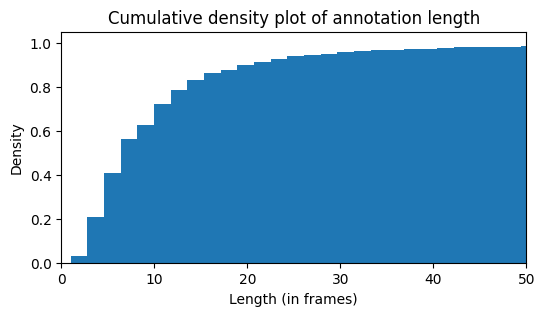

In [9]:
# Showing how long the annotations are (in frames)
plt.figure(figsize=(6,3))
plt.title('Cumulative density plot of annotation length')
plt.xlim(0,50)
plt.hist(ann_lengths, bins = 250, cumulative = True, density = True)
plt.xlabel('Length (in frames)')
plt.ylabel('Density')
plt.show()

In [10]:
print('Mean annotation length', np.median(ann_lengths))

total = smaller + larger + precise
print('Number of annotations, smaller than {0} frames, larger than {0} frames, exactly {0} frames'.format(fixed_length))
print(total, round(smaller/total, 2), round(larger/total, 2), round(precise/total, 2))

Mean annotation length 8.0
Number of annotations, smaller than 10 frames, larger than 10 frames, exactly 10 frames
110435 0.63 0.32 0.05


# Further processing data

In [11]:
top_suffix = '_top' if len(top_signs) != 0 else ''

# Get the list of possible glosses
glosses = list(set(glosses))
print('Unique glosses:', len(glosses))

# https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
# Encode the glosses as numerical
le = preprocessing.LabelEncoder()
fitted = le.fit(glosses)

# Store the transformations of the glosses in a dictionary
# I.e. string label -> int label
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
store_dict(PATHS['label_encoder'].format(top_suffix), dictionary)

Unique glosses: 2894


In [12]:
# New num. annotations for train, test set (filtering by present ratio, removing NaNs)
def prep_X(X):
    X = X.reshape(*X.shape[:-2], -1).astype(np.float32)
    X = np.nan_to_num(X)
    return X

datasets = ['Train', 'Train (no mirror)', 'Validation', 'Test']
total_instances = 0
normalize = True

# Get the mean & std of the (non-augmented) train data
X[1] = np.nan_to_num(X[1])
X_shape = X[1].shape
X_train_flat = X[1].reshape(-1, X_shape[-1])

if normalize:
    mean, std = np.mean(X_train_flat, axis = 0), np.std(X_train_flat, axis = 0)
    print(mean.shape, std.shape)
else:
    mean, std = np.zeros(X_shape[-1]), np.ones(X_shape[-1]) 
# Store the normalisation mean, std for later use
np.save(PATHS['normalisation'].format(features), [mean, std])

print('\tdataset \t\t\tdata shape \t\t label shape')
for i in range(len(X)):
    # Convert all to numpy
    X[i] = np.array(X[i])
    y[i] = np.array(y[i])
    
    # Convert NaN values to numerical
    X[i] = np.nan_to_num(X[i])
    
    # Transform the gloss labels (e.g. 'GEBAREN-A') to numerical (e.g. 123)
    y[i] = fitted.transform(y[i])
    # Make sure data has shape (num_data_points, num_frames, num_features)
    if len(X[i].shape) > 3:
        X[i] = prep_X(X[i])
        
    # Reuse train data mean, std for the other data
    if normalize:
        X[i], _, _ = norm(X[i], mean, std)
        
    # Store as float32 representation to save space, also required later when training 
    # Because otherwise it takes too much memory 
    X[i] = X[i].astype(np.float32) 
    print('{:<25}\t{:<20}\t\t{}'.format(datasets[i], str(X[i].shape), y[i].shape))
    if datasets[i] != 'Train':
        total_instances += X[i].shape[0]

# Get the train, validation, test data + labels
X_train, X_train_no_mirr, X_val, X_test = X
y_train, y_train_no_mirr, y_val, y_test = y

(120,) (120,)
	dataset 			data shape 		 label shape
Train                    	(180432, 10, 120)   		(180432,)
Train (no mirror)        	(90216, 10, 120)    		(90216,)
Validation               	(10500, 10, 120)    		(10500,)
Test                     	(9719, 10, 120)     		(9719,)


In [13]:
print('Total number of annotations:', total_instances)
for i in range(1, len(X)):
    print('{}: {}%'.format(datasets[i], round(X[i].shape[0]/total_instances*100)), end = '\t')

Total number of annotations: 110435
Train (no mirror): 82%	Validation: 10%	Test: 9%	

In [14]:
# We want to only keep validation and test examples
# Which have labels that have been seen during training (i.e. are in the train set)
in_train_labels = np.unique(y_train)
val_ind = np.where(np.isin(y_val, in_train_labels))[0]
test_ind = np.where(np.isin(y_test, in_train_labels))[0]
X_val, y_val = X_val[val_ind], y_val[val_ind]
X_test, y_test = X_test[test_ind], y_test[test_ind]
print(X_val.shape, X_test.shape)

(10295, 10, 120) (9585, 10, 120)


# Store datasets

In [15]:
# Save the datasets and labels to their respective numpy files
root = PATHS['data_linguistic'] if ling_features else PATHS['data_only_lmrks']
# PATHS format: X or y, type of data (train, val, test), features or not, top X signs 
np.save(root.format('X', 'train', features, top_suffix), X_train)
np.save(root.format('y', 'train', features, top_suffix), y_train)

np.save(root.format('X', 'train_no_mirror', features, top_suffix), X_train_no_mirr)
np.save(root.format('y', 'train_no_mirror', features, top_suffix), y_train_no_mirr)

np.save(root.format('X', 'val', features, top_suffix), X_val)
np.save(root.format('y', 'val', features, top_suffix), y_val)

np.save(root.format('X', 'test', features, top_suffix), X_test)
np.save(root.format('y', 'test', features, top_suffix), y_test) 

In [16]:
labels = load_dict(PATHS['label_encoder'].format(top_suffix))
labels['GEBOREN-A'], labels['AMSTERDAM'], labels['KLAAR-A'], labels['GEBAREN-A'], labels['NU-A']

(836, 182, 1252, 828, 1671)

In [17]:
len(list(labels.keys())), len(set(y_train.tolist()+y_val.tolist()+y_test.tolist()))

(2894, 2712)

In [18]:
len(list(labels.keys())), len(set(y_train.tolist()+y_val.tolist()+y_test.tolist()))

(2894, 2712)

In [19]:
def stats(X):
    shape = X.shape
    X_ = X.reshape(-1, shape[-1])
    mean, std = np.mean(X_, axis = 0), np.std(X_, axis = 0)
    print('Mean:', np.round(mean, 3))
    print('Std:', np.round(std, 3))
    return mean, std

In [20]:
X_test[0]

array([[-0.3276403 ,  0.08614154,  0.29545575, ..., -0.25420442,
        -0.02938755, -0.0848102 ],
       [-0.25153095, -0.11863157, -0.08191703, ..., -0.3858068 ,
        -0.02989083, -0.11474521],
       [-0.19076306, -0.06220169, -0.1908543 , ..., -0.12993106,
        -0.02952186, -0.13124824],
       ...,
       [-0.7711007 , -0.8268013 , -1.0079262 , ...,  0.01676895,
         0.03692219,  0.47454652],
       [-0.7711007 , -0.8268013 , -1.0079262 , ...,  0.01676895,
         0.03692219,  0.47454652],
       [-0.7711007 , -0.8268013 , -1.0079262 , ...,  0.01676895,
         0.03692219,  0.47454652]], dtype=float32)

In [21]:
print('X-train')
m, s = stats(X_train)
print('X-train (no mirroring)')
_, stats(X_train_no_mirr)
print('X-val')
_, stats(X_val)
print('X-test')
_, stats(X_test)

X-train
Mean: [ 0.06   0.005 -0.017 -0.001 -0.035 -0.032 -0.046 -0.046 -0.039  0.02
  0.037 -0.018  0.001 -0.03  -0.009 -0.039 -0.01  -0.034 -0.006 -0.063
 -0.024 -0.005  0.051 -0.009  0.015 -0.003 -0.053  0.121  0.137 -0.005
 -0.02  -0.018 -0.018 -0.016 -0.04  -0.04  -0.039 -0.031  0.    -0.016
 -0.027 -0.021 -0.034 -0.04   0.003 -0.232 -0.01  -0.298 -0.006 -0.226
 -0.007 -0.216 -0.007 -0.21  -0.007 -0.222 -0.001 -0.    -0.01  -0.054
 -0.005  0.017  0.001  0.036  0.034  0.047  0.049  0.04  -0.02  -0.034
  0.018 -0.003  0.029  0.007  0.04   0.009  0.034  0.005  0.083  0.027
  0.005 -0.046  0.009 -0.016  0.003  0.057 -0.106 -0.112  0.007  0.032
  0.029  0.029  0.025  0.071  0.071  0.066  0.049 -0.     0.025  0.046
  0.032  0.06   0.068  0.008  0.287 -0.014  0.333 -0.013  0.222 -0.015
  0.223 -0.014  0.228 -0.012  0.239  0.002  0.     0.007 -0.     0.477]
Std: [1.066 0.997 0.988 0.987 0.978 0.973 0.982 0.968 0.996 1.01  1.046 0.982
 0.993 0.981 0.996 0.975 0.993 0.997 0.996 0.889 0.93  1

(array([2.53613681e-01, 3.11915487e-01, 4.24956083e-01, 4.36278909e-01,
        4.44206417e-01, 4.15730953e-01, 4.39449191e-01, 4.19214666e-01,
        3.63622874e-01, 3.58287126e-01, 2.21675754e-01, 4.28245336e-01,
        4.66141313e-01, 4.48765397e-01, 4.57107037e-01, 4.45406049e-01,
        4.56981063e-01, 3.70115042e-01, 4.58872437e-01, 1.70196056e-01,
        1.84237257e-01, 1.27295375e-01, 1.75755605e-01, 2.70658880e-01,
        2.83833742e-01, 1.74119458e-01, 1.91823170e-01, 1.20807409e-01,
        1.19952217e-01, 9.51341391e-01, 2.26244068e+00, 2.26636887e+00,
        2.16071606e+00, 2.10232782e+00, 1.96300805e+00, 1.82394052e+00,
        1.63957596e+00, 1.57442248e+00, 9.54600394e-01, 1.50219500e+00,
        2.06653428e+00, 7.03904152e-01, 1.36563122e+00, 7.28469849e-01,
        3.25264359e+01, 3.01950902e-01, 7.18452263e+00, 6.39118999e-02,
        1.22606544e+01, 1.22876421e-01, 1.03560982e+01, 1.14124641e-01,
        1.02049503e+01, 1.04356594e-01, 9.91735649e+00, 9.370167

In [22]:
for i in range(m.shape[0]):
    if abs(m[i]) > 0.1:
        print(i, m[i])

27 0.12132182
28 0.13655487
45 -0.23175056
47 -0.2983415
49 -0.22623035
51 -0.21627036
53 -0.2102759
55 -0.22152936
86 -0.10555318
87 -0.111929104
104 0.2866404
106 0.3330637
108 0.22233176
110 0.2233677
112 0.22790277
114 0.23874095
119 0.47665817


# Finding highly correlated features

In [23]:
%%time
# Convert the variable length train data to numpy
X_train = np.array(X_train_var_len)
y_train = np.array(y_train_var_len)

# The above code gives us unevenly sized annotations, we can't just reshape
# So to add each frame as a row, we do it in a loop
x = []
for data_point in X_train:
    for frame in data_point:
        x.append(frame)
        
# We mask any NaN values so we can ignore them during later computations
x = np.array(x)
x = ma.masked_invalid(x)
x.shape

<timed exec>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: total: 2.03 s
Wall time: 2.08 s


(991431, 120)

In [24]:
%%time
# NOTE: this takes very long to compute (45-60 minutes on the tested hardware)
# This is why we try to avoid recomputing this if possible

# We compute the correlations between the values in the train data
corrs_path = PATHS['masked_corrs'].format(features)
cols = range(x.shape[-1]) # Number of columns = last dimension of x

# If we already computed the correlations, reuse them
if os.path.exists(corrs_path):
    print('Corrs being loaded...')
    corrs = np.load(corrs_path)
    # We need to convert to a masked array (can't save it like that)
    if 'masked' in corrs_path:
        corrs = ma.masked_invalid(corrs)
    corrs = list(corrs)
else: # Else, compute the correlations (this takes a while)
    print('Corrs being created...')    
    print('Data shape:', x.shape)

    corrs = []
    for col_1 in range(x.shape[-1]-1):
        for col_2 in range(col_1+1, x.shape[-1]):
            print(col_1, end = '\r')
            corr = ma.corrcoef(x[:,col_1], x[:, col_2])[0][1]
            corrs.append((corr, col_1, col_2))
    corrs_np = np.array(corrs)
    np.save(corrs_path, corrs_np)
print('Done.')

Corrs being loaded...
Done.
CPU times: total: 547 ms
Wall time: 1.73 s


In [25]:
# Continuation of the block above this one
print('Total correlations:\t\t{}'.format(len(corrs)))
num_high_corr = 0
high_corrs = []
removable = []
corr_thresh = 0.9
for corr in corrs:
    if abs(corr[0]) >= corr_thresh:
        corr = [corr[0], int(corr[1]), int(corr[2])]
        high_corrs.append(tuple(corr))
        # Remove the first feature of the high corr. pair
        removable.append(sorted(corr[1:])[-1])
        num_high_corr += 1
print('Num. of correlations >= {}:\t{}'.format(corr_thresh, num_high_corr))
to_remove = list(set(removable))

print('\nTo be removed:', to_remove)
remain = set(cols) - set(to_remove)

print('\nNumber of features we remove:', len(to_remove))
print('Number of features remaining:', len(list(remain)))

print('\n\nHigh correlation tuples:\n')
print(sorted(high_corrs, key = lambda x: x[0], reverse = True))

Total correlations:		17205
Num. of correlations >= 0.9:	153

To be removed: [4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 58, 60, 62, 64, 78, 81, 82, 83, 84, 85, 89, 90, 99, 101, 104, 105, 106, 107, 108, 109, 113, 116, 117, 119, 120, 121, 122, 123, 125, 127, 128, 132, 134, 136, 137, 151, 153, 155, 157, 176, 177, 178, 182, 183]

Number of features we remove: 78
Number of features remaining: 62


High correlation tuples:

[(0.9943165855140784, 45, 89), (0.9918441357961455, 82, 84), (0.9893162577629346, 80, 82), (0.9892193413958957, 11, 13), (0.9842315284750854, 30, 39), (0.9827891844639115, 104, 106), (0.982537440669893, 14, 16), (0.9824167715314849, 32, 41), (0.9820252182266592, 81, 83), (0.9812951095231047, 2, 24), (0.979499483673376, 83, 85), (0.979073845470561, 0, 11), (0.9789532799169358, 12, 14), (0.9784303378670371, 107, 109), (0.97772141733992, 4, 30), (0.9736093517757927, 46, 90), (0.972737211

In [26]:
# Analyze which features remain
def feature_selection_analysis(num_features, to_remove):
    half_features = round(num_features/2) - 1
    print(half_features)
    rem = set(range(x.shape[-1])) - set(to_remove)
    print('Remain length:', len(rem))
    rem_first = [r for r in sorted(rem) if r <= half_features]
    rem_second = [r-(half_features+1) for r in sorted(rem) if r > half_features]
    print('Remaining of left hand:')
    print(rem_first, '({} features)'.format(len(rem_first)))
    print('Remaining of right hand:')
    print(rem_second, '({} features)'.format(len(rem_second)))

    print('Extra features right hand:', sorted(set(rem_second) - set(rem_first)))
    print('Extra features left hand:', sorted(set(rem_first) - set(rem_second)))
    
    print('Same for both hands:', sorted(set(rem_second) & set(rem_first)))
# We use cols to get the number of features
feature_selection_analysis(len(cols), to_remove)

59
Remain length: 62
Remaining of left hand:
[0, 1, 2, 3, 5, 7, 10, 22, 25, 33, 40, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59] (25 features)
Remaining of right hand:
[1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 50, 51, 52, 54, 55, 58] (37 features)
Extra features right hand: [6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 26, 27, 28, 31, 32, 34, 35, 36, 37, 38, 42, 43, 58]
Extra features left hand: [0, 2, 22, 25, 45, 46, 47, 48, 49, 53, 56, 57, 59]
Same for both hands: [1, 3, 5, 7, 10, 33, 40, 50, 51, 52, 54, 55]


In [27]:
# We round the values in the correlations, then remove masked values because we can't count them
# Then we print a counter of the (rounded) correlations
corrs_round = np.ma.array([np.round(c[0], 1) for c in corrs])
corrs_round_not_masked = corrs_round[~corrs_round.mask].flatten()
corrs_round_not_masked += 0. # This removes values that are rounded to -0.0, sets them to 0.0 (no minus)
print(Counter(corrs_round_not_masked))

Counter({0.0: 11520, 0.1: 1470, -0.1: 832, 0.7: 594, 0.6: 508, 0.8: 420, 0.2: 417, 0.9: 240, 0.5: 212, -0.2: 207, 0.3: 194, 0.4: 78, 1.0: 54, -0.3: 49, -0.4: 24, -0.5: 5, -0.6: 5, -0.7: 4, -0.8: 3})


d:\program files (x86)\python39\lib\site-packages\numpy\ma\core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
